author: Zhongzhi Hu

4 December 2023

**0. Introduction**

In this code, a neural network is trained to identify trading patterns in the S&P 500 Index. The model is trained using daily closing prices of the S&P 500 Index from 1990 to 2007. Subsequently, a trading simulation is conducted on an out-of-sample period spanning from 2008 to 2023. The simulation involves adjusting long and short allocations in the S&P 500 Index. These allocations are not leveraged and can range from -100% to 100% of the available balance, depending on the magnitude of the predicted next-day returns. Allocations are adjusted on a daily basis and occurs at market close. Any remaining balance not allocated to the S&P 500 Index is accrued by the Risk-Free Rate (US 10-Year Treasury Note).

**1. Import libraries**

In [28]:
# Import libraries
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# Import drive from Google Colab library to access uploaded data
from google.colab import drive

# Set random seed for reproducibility
seed_value = 77
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


**2. Import S&P Index data**

In [29]:
#%% Import Stock Data downloaded from
# https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

# Obtain access to data uploaded to Google drive
drive.mount('/content/drive')

# Import CSV file
df = pd.read_csv("/content/drive/MyDrive/trading_project/HistoricalPrices_WSJ.csv")

# Remove whitespaces from all column names
df.columns = [col.strip() for col in df.columns]

# Remove columns not used for our analysis
df.drop(['Open', 'High', 'Low'], inplace=True, axis=1)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Rename column
df.rename(columns={"Close": "SP500Close"}, inplace=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**3. Create features from public market data**

In [30]:
#%% Create features

# Create daily returns in percentages
df['Return'] = df['SP500Close'].pct_change()

# Create feature: lagged returns
for i in range(1, 8):
    df[f'Return{i}DayAgo'] = df['Return'].shift(i)

# Create return next day (realized)
df['SP500ReturnNextDay'] = df['Return'].shift(-1)

# Erase Nan Data (it concerns oldest and newest observations)
df = df.dropna(subset=['SP500ReturnNextDay', 'Return7DayAgo'])
df = df.reset_index(drop=True)

# Create extra feature 'Consecutive_Days' which represents the consecutive
# days of losses or gains. E.g. a value of -3 denotes that the trading day
# is preceded by 3 days of consecutive losses. A value of positive 3 denotes
# that the trading day is preceded by 3 days of consecutive gains.

# Create a column 'Consecutive_Days' and initialize it with 0
df['Consecutive_Days'] = 0

# Identify days with consecutive wins (positive returns)
consecutive_wins = (df['Return'] > 0).astype(int).groupby(df['Return'].lt(0).cumsum()).cumsum()

# Identify days with consecutive losses (negative returns)
consecutive_losses = (df['Return'] < 0).astype(int).groupby(df['Return'].gt(0).cumsum()).cumsum()

# Update 'Consecutive_Days' based on consecutive wins and losses
df.loc[df['Return'] > 0, 'Consecutive_Days'] = consecutive_wins
df.loc[df['Return'] < 0, 'Consecutive_Days'] = -consecutive_losses


**4. Import US 10 Y Treasury Note data**



In [31]:
#%% Import Risk Free Rate Data: US Treasury Rate 10Y downloaded from
# https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD10Y/historical-prices

# Import CSV file
df_T = pd.read_csv("/content/drive/MyDrive/trading_project/HistoricalPrices_T10Y_WSJ.csv")

# Remove whitespaces from all column names
df_T.columns = [col.strip() for col in df_T.columns]

# Convert the 'Date' column to datetime format
df_T['Date'] = pd.to_datetime(df_T['Date'])

# Remove columns not used for our analysis
df_T.drop(['Open', 'High', 'Low'], inplace=True, axis=1)

# Rename column
df_T.rename(columns={"Close": "10YRiskFreeRate"}, inplace=True)

# Divide by 100 to denote percentages
df_T['10YRiskFreeRate'] = df_T['10YRiskFreeRate'] / 100

# Further divide by 365 since SP500 and Portfolio returns are on daily basis
df_T['10YRiskFreeRate'] = df_T['10YRiskFreeRate'] / 365

# Left join on earlier dataframe to add risk free rate
df = pd.merge(df, df_T, on='Date', how='left')

# Impute missing values (nan) by taking surrounding mean
df['10YRiskFreeRate'] = df['10YRiskFreeRate'].fillna(df['10YRiskFreeRate'].rolling(window=3,
                                                                                   min_periods=1,
                                                                                   center=True).mean())


**5. Plot S&P 500 Index**

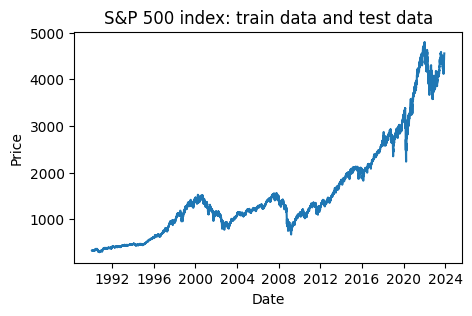

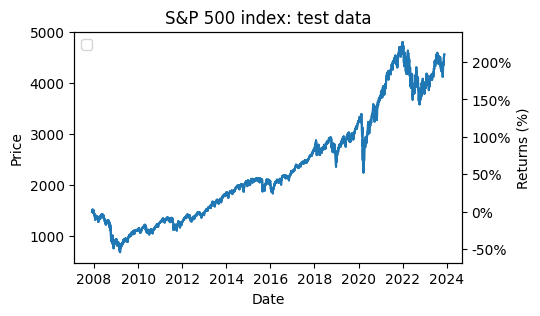


The total returns of the S&P 500 over the test period amount to: 210.03%
The compounded annual growth rate (CAGR) of the S&P500 over the test period amounts to: 7.34%



In [49]:
#%% Plot S&P 500 index

# Split data into train and test data. Test data is chosen to include period of
# stable economic growth and financial crises (2008 GFC and COVID 19)
df_train = df[:4500]
df_test = df[4500:]

# Time series S&P index. Period: Train and Test Data
plt.figure(figsize=(5, 3))
plt.plot(df['Date'], df['SP500Close'])
plt.title('S&P 500 index: train data and test data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Print newline between the two plots
print("\n")

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot the Price level on the left y-axis
ax1.plot(df_test['Date'], df_test['SP500Close'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.tick_params('y')
ax1.set_title('S&P 500 index: test data')

# Create a secondary y-axis for Relative Returns
ax2 = ax1.twinx()
relative_returns = ((df_test['SP500Close'] - df_test['SP500Close'].iloc[0]) / df_test['SP500Close'].iloc[0]) * 100

# Plot the Relative Returns on the right y-axis
ax2.plot(df_test['Date'], relative_returns)
ax2.set_ylabel('Returns (%)')
ax2.tick_params('y')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Display the legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

# Print returns of trading simulation
print("\n" + f"The total returns of the S&P 500 over the test period amount to: {relative_returns.iloc[-1]:.2f}%")

# Calculate CAGR for the S&P 500 index
t_end = df_test['Date'].iloc[-1]
t_start = df_test['Date'].iloc[0]
n_years = (t_end - t_start).days/365.25
cagr_sp = ((df_test['SP500Close'].iloc[-1]/df_test['SP500Close'].iloc[0])**(1/n_years)-1)*100
print(f"The compounded annual growth rate (CAGR) of the S&P500 over the test period amounts to: {cagr_sp:.2f}%" + "\n")

**6. Plot distribution of the S&P returns conditional on the losses/gains of the preceding days**

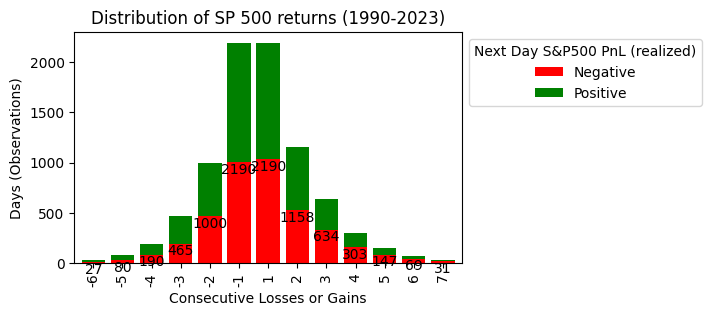

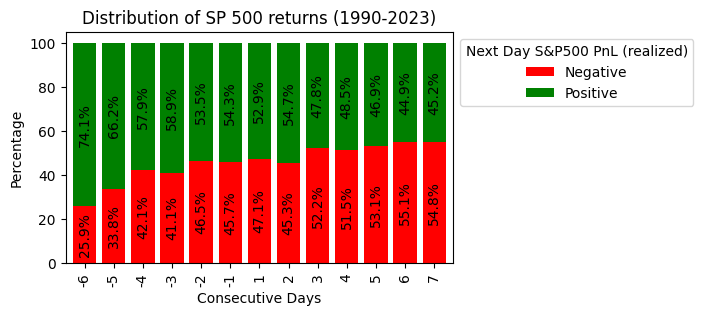

In [33]:

def plot_count_and_percentage(data, min_observations=25, figsize=(5, 3)):
    """
    Plot bar charts for counts and percentages of profitable and negative returns.

    Parameters:
    - data: Input DataFrame.
    - min_observations (int): Minimum number of observations to include in the plot.
    - figsize (tuple): Figure size.

    Returns:
    - None
    """
    # Create a new column 'Next_Day_Sign' to represent the sign of the return on the next day
    data['Next_Day_Sign'] = data['SP500ReturnNextDay'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

    # Group by consecutive days and next day sign, then count occurrences
    grouped_data = data.groupby(['Consecutive_Days', 'Next_Day_Sign']).size().unstack().fillna(0)

    # Delete rows with less than min_observations observations
    grouped_data = grouped_data[(grouped_data['Negative'] + grouped_data['Positive']) >= min_observations]

    # Calculate percentages
    grouped_data_percentage = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

    # Plotting Count
    fig, ax_count = plt.subplots(figsize=figsize)  # Adjusted figsize

    # Stack bar chart for consecutive gains and losses with counts
    grouped_data.plot(kind='bar', stacked=True, ax=ax_count,
                      color=['red', 'green'], width=0.8)

    # Customize the count plot
    ax_count.set_xlabel('Consecutive Losses or Gains')
    ax_count.set_ylabel('Days (Observations)')
    ax_count.set_title('Distribution of SP 500 returns (1990-2023)')
    ax_count.legend(title='Next Day S&P500 PnL (realized)', bbox_to_anchor=(1, 1))  # Move legend outside the plot

    # Add total count above each bar
    for p, total_count in zip(ax_count.patches, grouped_data.sum(axis=1)):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if total_count != 0:
            ax_count.text(x + width / 2,
                          y + height + 0.5,  # Adjusted to display above the entire stacked bar
                          int(total_count),  # Remove decimal
                          ha='center',
                          va='top',  # Adjusted to ensure the number is on top of the stacked bar
                          rotation=0)  # No rotation for total count

    # Show the count plot
    plt.show()

    # Print newline between the two plots
    print("\n")

    # Plotting Percentage
    fig, ax_percentage = plt.subplots(figsize=figsize)  # Adjusted figsize

    # Stack bar chart for consecutive gains and losses with percentages
    grouped_data_percentage.plot(kind='bar', stacked=True, ax=ax_percentage,
                                 color=['red', 'green'], width=0.8)

    # Customize the percentage plot
    ax_percentage.set_xlabel('Consecutive Days')
    ax_percentage.set_ylabel('Percentage')
    ax_percentage.set_title('Distribution of SP 500 returns (1990-2023)')
    ax_percentage.legend(title='Next Day S&P500 PnL (realized)',
                         bbox_to_anchor=(1, 1))  # Move legend outside the plot

    # Add labels to the bars with percentages
    for p in ax_percentage.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = '{:.1f}%'.format(height)
        if height != 0.0:
            ax_percentage.text(x + width / 2,
                               y + height / 2,
                               percentage,
                               ha='center',
                               va='center',
                               rotation=90,
                               rotation_mode='anchor')

    # Show the percentage plot
    plt.show()

plot_count_and_percentage(df)

In the preceding plots, in the period 1990 to 2023, we observe that after experiencing several consecutive days of losses in the S&P500 Index, the likelihood of an actual gain in the index on the following day increases and is above 50%. Conversely, during winning streaks of the S&P500 Index lasting 3 days or more, the probability of a gain on the next day is observed to be smaller than 50%. Therefore, it is worth investigating to train a Neural Network to recognize trading patterns based on past consecutive loss and win streaks.

**7. Train Neural Network**



In [34]:
#%% Neural Network model training

# Define function for training Neural Network
def train_neural_network(df_train, df_test, features, hidden_layers):

    # Select train and test data
    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train['SP500ReturnNextDay']
    y_test = df_test['SP500ReturnNextDay']

    # Build the neural network model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(hidden_layers[0], activation='relu',
                                    input_shape=(X_train.shape[1],)))

    for neurons in hidden_layers[1:]:
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    # Output layer (linear activation unit due to  positive and negative returns)
    model.add(tf.keras.layers.Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model on the train data
    model.fit(X_train, y_train, epochs=50, batch_size=64,
              validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model on the test data
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Mean Absolute Error on Test Data: {mae}")

    return model

# Train Neural Network model
features = ['Return', 'Return1DayAgo', 'Return2DayAgo', 'Return3DayAgo',
            'Return4DayAgo', 'Return5DayAgo', 'Consecutive_Days']
trained_model = train_neural_network(df_train,
                                     df_test, features, [32, 64, 32])

# Make predictions
df_test['pred'] = trained_model.predict(df_test[features])

126/126 [==============================] - 0s 3ms/step - loss: 2.6982e-04 - mae: 0.0113
Mean Absolute Error on Test Data: 0.01127929799258709
126/126 [==============================] - 0s 2ms/step


<ipython-input-34-a3fd4c97e19c>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred'] = trained_model.predict(df_test[features])


**8. Run Trading simulation on out-of-sample data (2008-2023)**

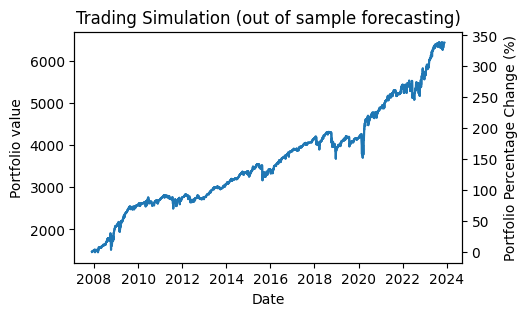


The total returns of the portfolio over the test period amount to: 338.21%
The compounded annual growth rate (CAGR) of the portfolio over the test period amounts to: 9.68%



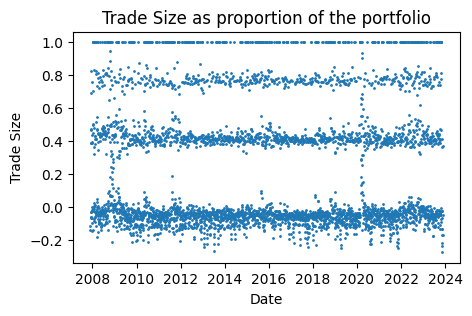


Over time, the average absolute portfolio allocation to the S&P500 index is: 31.91%



In [47]:
def run_trading_simulation(df, initial_cash, threshold=0.02):
    """
    Runs trading simulation and plots the portfolio value over time

    Parameters:
    - data: Input DataFrame of test data.
    - initial_cash (float): starting value of the portfolio balance
    - threshold (int): number to

    Returns:
    - None
    """

    # Ensure index starts at 0
    df = df.reset_index(drop=True)

    # Initialize columns for daily P&L, bet size, and balance
    df['Daily_PnL'] = 0.0
    df['Bet_size'] = 0.0
    df['Balance_pre_PnL'] = initial_cash
    df['Balance_post_PnL'] = 0.0

    # Iterate over the DataFrame rows for trading simulation
    for index, row in df.iterrows():
        # For the first row, use initial_cash instead of Balance_pre_PnL
        if index == 0:
            bet_size = initial_cash * row['pred'] / threshold
        else:
            # Calculate the bet size based on the predicted return
            if abs(row['pred']) >= threshold:
                bet_size = df.at[index - 1, 'Balance_post_PnL'] * (1 if row['pred'] >= 0 else -1)
            else:
                bet_size = abs(row['pred']) / threshold * df.at[index - 1, 'Balance_post_PnL'] * (1 if row['pred'] >= 0 else -1)

        # Calculate the daily P&L
        daily_pnl = bet_size * row['SP500ReturnNextDay']

        # Update the balance columns
        balance_pre_pnl = initial_cash if index == 0 else df.at[index - 1, 'Balance_post_PnL']
        interest = (balance_pre_pnl - abs(bet_size)) * row['10YRiskFreeRate']
        balance_post_pnl = balance_pre_pnl + daily_pnl + interest

        # Update the DataFrame with daily P&L, bet size, and balance
        df.at[index, 'Bet_size'] = bet_size
        df.at[index, 'Daily_PnL'] = daily_pnl
        df.at[index, 'Interest'] = interest
        df.at[index, 'Balance_pre_PnL'] = balance_pre_pnl
        df.at[index, 'Balance_post_PnL'] = balance_post_pnl

    df['Percentage_Change'] = (df['Balance_post_PnL'] / df['Balance_post_PnL'].iloc[0] - 1) * 100  # Calculate wealth change

    plt.figure(figsize=(5, 3))

    # Plotting Balance_post_PnL on the left y-axis
    plt.plot(df['Date'], df['Balance_post_PnL'], label='Balance_post_PnL')
    plt.xlabel('Date')
    plt.ylabel('Portfolio value')

    # Creating a second y-axis on the right for percentage change
    plt.twinx()
    plt.plot(df['Date'], df['Percentage_Change'], label='Percentage Change')
    plt.ylabel('Portfolio Percentage Change (%)')

    plt.title('Trading Simulation (out of sample forecasting)')
    plt.show()

    return df

# Run trading simulation on test data
result_df = run_trading_simulation(df_test,
                                   initial_cash=df_test['SP500Close'].iloc[0])

# Print returns of trading simulation
print("\n" + f"The total returns of the portfolio over the test period amount to: {result_df['Percentage_Change'].iloc[-1]:.2f}%")


# Calculate CAGR
t_end = result_df['Date'].iloc[-1]
t_start = result_df['Date'].iloc[0]
n_years = (t_end - t_start).days/365.25
cagr = ((result_df['Balance_post_PnL'].iloc[-1]/result_df['Balance_pre_PnL'].iloc[0])**(1/n_years)-1)*100
print(f"The compounded annual growth rate (CAGR) of the portfolio over the test period amounts to: {cagr:.2f}%" + "\n")


# Time series plot of relative bet_size
plt.figure(figsize=(5, 3))
plt.scatter(result_df['Date'], result_df['Bet_size']/result_df['Balance_pre_PnL'], s=1)
plt.title('Trade Size as proportion of the portfolio')
plt.xlabel('Date')
plt.ylabel('Trade Size')
plt.show()

# Calculate proportion invested in trading simulation
avg_invested = abs(result_df['Bet_size']/result_df['Balance_pre_PnL']).mean()*100
print("\n" + f"Over time, the average absolute portfolio allocation to the S&P500 index is: {avg_invested:.2f}%" + "\n")


**9. Calculate Sharpe Ratio**

The Sharpe Ratio is a measure for risk-adjusted returns. The Sharpe Ratio is calculated both for the trading portfolio driven by our automated model and the S&P 500 Index.

In [39]:
#%% Statistics:
#   Calculate Sharpe Ratio for SP500 index vs Portfolio

# Take relevant cols of test data
sharpe_df = result_df[['Date', 'SP500ReturnNextDay']]

# Calculate portfolio return of the trading account
sharpe_df['Portf_Return'] = result_df['Daily_PnL'] / result_df['Balance_pre_PnL']

# Left join to add risk free rate
sharpe_df = pd.merge(sharpe_df, df_T, on='Date', how='left')

# Calculate excess returns
sharpe_df['SP500ExcessReturn'] = sharpe_df['SP500ReturnNextDay'] - sharpe_df['10YRiskFreeRate']
sharpe_df['PortfExcessReturn'] = sharpe_df['Portf_Return'] - sharpe_df['10YRiskFreeRate']

# Calculate mean and standard deviation of excess returns
mean_excess_return_sp = sharpe_df['SP500ExcessReturn'].mean()
std_excess_return_sp = sharpe_df['SP500ExcessReturn'].std()

mean_excess_return_portfolio = sharpe_df['PortfExcessReturn'].mean()
std_excess_return_portfolio = sharpe_df['PortfExcessReturn'].std()

# Calculate Sharpe Ratio
sharpe_ratio_sp = mean_excess_return_sp / std_excess_return_sp
sharpe_ratio_portfolio = mean_excess_return_portfolio / std_excess_return_portfolio

print(f"Sharpe Ratio for S&P500 Index: {sharpe_ratio_sp}")
print(f"Sharpe Ratio for Portfolio: {sharpe_ratio_portfolio}")
print("\n" + f"The Sharpe Ratio for the Portfolio is {(sharpe_ratio_portfolio/sharpe_ratio_sp-1)*100:.2f}% higher than for the S&P 500 Index" + "\n")



Sharpe Ratio for S&P500 Index: 0.024199764217933628
Sharpe Ratio for Portfolio: 0.03812460991394674

The Sharpe Ratio for the Portfolio is 57.54% higher than for the S&P 500 Index



<ipython-input-39-b12739fd9722>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharpe_df['Portf_Return'] = result_df['Daily_PnL'] / result_df['Balance_pre_PnL']


The Sharpe Ratio for our Portfolio driven by the automated trading model has a higher (=better) Sharpe Ratio , and therefore outperforms the performance of the S&P 500 Index over the test data period. The significant difference of 57.54% in the Sharpe ratio can be attributed to

1.   The outperformance of the returns of the Portfolio over the S&P 500 Index
2.   Lower volatility of returns. Please note that although the portfolio did decrease in value during the 2008 Global Financial Crisis and the Covid19 Pandemic, the portfolio value decrease is far less severe than observed in the S&P500 Index in the same periods.



**10. Conclusion**

The trading simulation, driven by the Neural Network trained to identify trading patterns based on past observations, performs exceptionally well during the test data period. Despite the relatively low allocation of the portfolio to the S&P 500 Index over time, the portfolio has demonstrated significant outperformance compared to the S&P 500 Index, both in terms of returns and risk-adjusted returns. This is attributed to its impressive ability to accurately predict next-day returns.

It is important to note, however, that trading costs, while relatively low for professional trading firms, have not been factored into this analysis. These costs should be taken into account when implementing such an automated trading strategy in real-world scenarios. Additionally, in practical applications, the trading frequency may be adjusted to be less frequent based on the magnitudes of the model predictions.